# HumanEval Plot

In [1]:
import numpy as np
import torch
import pandas as pd
from tqdm.auto import tqdm
import pickle
import copy
import sys
from os import path
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer, Rotator

import sys
sys.path.append('../sloth/')
from sloth import *
from definitions import *

device = 'cpu'

In [2]:
data = pd.read_csv('../data/data_v2.csv')
data['logS'] = np.log10(data['#Params (B)'])
data['logT'] = np.log10(data['Pretraining Data Size (T)'])
data['logSlogT'] = data['logS']*data['logT']
#data['logS2'] = data['logS']**2
#data['logT2'] = data['logT']**2
data['GreatFamily'] = data['Family']
data['Family'] = data['Family2']
X_names = ['logS','logT','logSlogT'] 
Y_agentic = ['MMLU', 'HellaSwag', 'HellaSwag', 'Winogrande', 'IFEval']
Y_names = ['GSM8K',
           'MATH Lvl 5',
           'GPQA',
           'MMLU',
           'MMLU-PRO',
           'BBH',
           'MUSR',
           'TruthfulQA',
           'ARC',
           'HellaSwag',
           'Winogrande',
           'IFEval']
Y_OOD = ['HumanEval']
data_sloth = data.loc[:,['Model','Family','GreatFamily','Instruct']+X_names+Y_names].dropna()
holdout_names = ['meta-llama-3-70b-instruct', 'meta-llama-3-70b']
data_hold = data.loc[data['Model'].isin(holdout_names)]
Models_dict = {k: v for v, k in enumerate(list(data_sloth['Model']))}
to_drop = []
for model in holdout_names:
    to_drop.append(Models_dict[model])
to_drop.sort()
#for name in holdout_names:
    #data_sloth = data_sloth[data.Model != name]
#data_tr = data.loc[:,['Model','Family','GreatFamily','Instruct']+X_names+Y_names]
data_OOD = data.loc[:,['Model','Family','GreatFamily','Instruct']+X_names+Y_names+['HumanEval']].dropna()
for name in holdout_names:
    data_OOD = data_OOD[data.Model != name]
D_whole = np.array(pd.get_dummies(np.array(data_sloth.Family))).astype(float)
D = np.delete(D_whole, to_drop, axis=0)
#D = np.ones(38)[np.newaxis, :].T
X_whole = np.array(data_sloth.loc[:,X_names]).astype(float)
X = np.delete(X_whole, to_drop, axis=0)
Y_whole = np.array(data_sloth.loc[:,Y_names]).astype(float)
Y = np.delete(Y_whole, to_drop, axis=0)
Cs = []
for s in Y_names:
    Cs.append(lower_bounds[s])
Cs = np.array(Cs).astype(float)[None,:]
Y.shape

/tmp/ipykernel_9218/2487333736.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_OOD = data_OOD[data.Model != name]
/tmp/ipykernel_9218/2487333736.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_OOD = data_OOD[data.Model != name]


(77, 12)

In [3]:
model = Sloth(d=3)
model.fit(X_whole, D_whole, Y_whole, Cs, fit_C=False, train_link=False, positive_w=False, verbose=True)
#model.fit(X, D, Y, Cs, fit_C=False, train_link=False, positive_w=False, verbose=True)
#model.best_loss
d= 3
if d==1:
    L_rot=-model.W2.numpy()
    B_rot=-np.vstack((model.W1_X.detach().numpy(), model.W1_D.detach().numpy()))
    Z = np.hstack((X,D))@B_rot
else:
    Z = model.interpret(anchor=0)['skills']
    L_rot = model.interpret(anchor=0)['loadings']
    B_rot = model.interpret(anchor=0)['B']
    Delta = model.interpret(anchor=0)['translation']
for name in holdout_names:
    data_sloth = data_sloth.loc[data.Model != name]
Skills_dict = {k: v for v, k in enumerate(list(data_sloth['Model']))}
to_keep = []
for model in list(data_OOD['Model']):
    to_keep.append(Skills_dict[model])
X_tr = Z[to_keep]
Inter_train  = np.ones(X_tr.shape[0])[np.newaxis, :].T
Y_tr = np.array(data_OOD.loc[:,'HumanEval']).astype(float)
Y_tr = Y_tr[np.newaxis, :].T
Y_tr.shape
D_hold = D_whole[to_drop]
#D_hold = D[to_drop]
X_hold = X_whole[to_drop]
Y_hold = np.array(data_hold.loc[:,'HumanEval']).astype(float)
Y_hold = Y_hold[np.newaxis, :].T
Y_hold.shape


  0%|          | 0/100000 [00:00<?, ?it/s]

0.09999999999999999 0.024393798783421516


  0%|          | 0/100000 [00:00<?, ?it/s]

0.01 0.024406706914305687


  0%|          | 0/100000 [00:00<?, ?it/s]

0.001 0.024542909115552902


(2, 1)

In [4]:
model_ood = Sloth(d=1) 
model_ood.fit(X_tr, Inter_train, Y_tr,
                                      C0=np.array([[0]]),
                                      train_link=False, fit_C=False, positive_w=False, verbose=False)
Z_hold = np.hstack((X_hold,D_hold))@B_rot-Delta
B_ood=np.vstack((model_ood.W1_X.detach().numpy(), model_ood.W1_D.detach().numpy()))

In [5]:
## Ruan et als method
import numpy as np
from sklearn.decomposition import PCA
#d=1
pca = PCA(n_components=3)
pca.fit(Y_whole)
X_ruan=pca.transform(Y_whole)[to_keep]
model_ood_ruan = Sloth(d=1) 
model_ood_ruan.fit(X_ruan, Inter_train, Y_tr,
                                      C0=np.array([[0]]),
                                      train_link=False, fit_C=False, positive_w=False, verbose=False)
Z_hold_ruan = pca.transform(Y_whole)[to_drop]
B_ood_ruan = np.vstack((model_ood_ruan.W1_X.detach().numpy(), model_ood_ruan.W1_D.detach().numpy()))

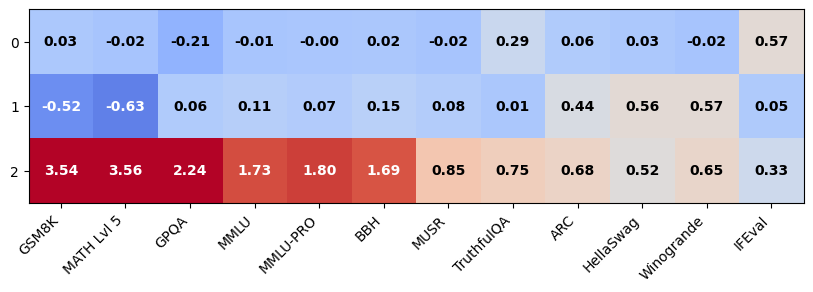

In [6]:
colormap = 'coolwarm'
vmin=-1
vmax=2
#factor_labels = ['Instruction Following, Knowledge, Reasoning']
plt.figure(figsize=(10, 6))  # Set the figure size (width, height) in inches
plt.imshow(L_rot, cmap=colormap, vmin=vmin, vmax=vmax)
plt.xticks(np.arange(len(Y_names)), labels=Y_names, rotation=45, ha="right")  # Set the x-tick labels
plt.yticks(np.arange(d), rotation=0, ha="right")

inter = [-.3,1.6]
for i in range(len(L_rot)):
    for j in range(len(L_rot.T)):
        value = L_rot[i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = plt.text(j, i, f'{value:.2f}', size=10, ha="center", va="center", color=color, weight='bold')#
plt.savefig('../plots/Lambda_rebuttal.pdf', bbox_inches='tight')
plt.show()

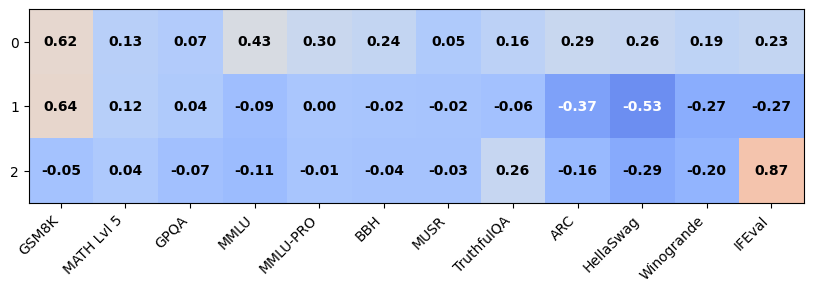

In [7]:
colormap = 'coolwarm'
vmin=-1
vmax=2
L_rot = pca.components_
#factor_labels = ['Instruction Following, Knowledge, Reasoning']
plt.figure(figsize=(10, 6))  # Set the figure size (width, height) in inches
plt.imshow(L_rot, cmap=colormap, vmin=vmin, vmax=vmax)
plt.xticks(np.arange(len(Y_names)), labels=Y_names, rotation=45, ha="right")  # Set the x-tick labels
plt.yticks(np.arange(d), rotation=0, ha="right")

inter = [-.3,1.6]
for i in range(len(L_rot)):
    for j in range(len(L_rot.T)):
        value = L_rot[i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = plt.text(j, i, f'{value:.2f}', size=10, ha="center", va="center", color=color, weight='bold')#
plt.savefig('../plots/ruan_loadings.pdf', bbox_inches='tight')
plt.show()

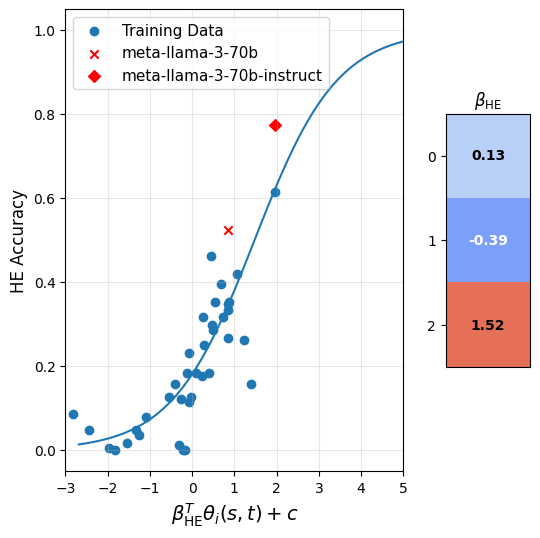

In [8]:
x, y = np.concatenate((X_tr, Inter_train), axis = 1) @ B_ood, Y_tr
x_test, y_test = np.concatenate((Z_hold, np.ones(2)[np.newaxis, :].T), axis = 1) @ B_ood, Y_hold
a, b, c, e = np.linspace(-2, 10, 100), np.linspace(-2, 10, 100), np.linspace(-2, 10, 100), np.linspace(-2, 10, 100)
Grid = np.vstack((a.flatten(), b.flatten(), c.flatten())).T
y_curve = model_ood.predict(Grid, np.array([[1]]))
x_grid = np.concatenate((Grid, np.ones(100)[np.newaxis, :].T), axis = 1) @ B_ood
colormap = "coolwarm"
vmin=-1
vmax=2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,6), width_ratios=[4, 1])
 # Set the figure size (width, height) in inches
#ax1.set_figwidth(6)
#ax1.set_figheight(3)
Bperm = B_ood.copy()
#Bperm[[0,1,2]] = Bperm[[0, 2,1]]
ax2.imshow(Bperm[0:3], cmap=colormap, vmin=vmin, vmax=vmax)
inter = [-.3,1.6]
for i in range(len(B_ood[0:3])):
    for j in range(len(B_ood[0:3].T)):
        value = Bperm[0:3][i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = ax2.text(j, i, f'{value:.2f}', size=10, ha="center", va="center", color=color, weight='bold')#
ax2.set_xticks([], [])  # Set the x-tick labels
ax2.set_yticks(np.arange(d))  # Set the y-tick labels
ax2.set_title('$\\beta_{\\text{HE}}$', size = 12)
#ax2.tick_params(labelsize=11)
ax1.scatter(x,y, label = 'Training Data')
ax1.scatter(x_test[0],y_test[0], color = 'red', label = 'meta-llama-3-70b', marker = 'x')
ax1.scatter(x_test[1],y_test[1], color = 'red', label = 'meta-llama-3-70b-instruct', marker = 'D')
ax1.set_xlim(-3, 5)
#ax2.ylim(0,1)
ax1.set_xlabel('$\\beta_{\\text{HE}}^T\\theta_{i}(s,t) +c$', size = 14)
ax1.grid(alpha = 0.3)
ax1.plot(x_grid, y_curve)
ax1.set_ylabel('HE Accuracy', size = 12)
#ax2.tick_params(labelsize=11)
ax1.legend(prop={'size':11}, loc = 'upper left')
plt.savefig('../plots/HE_Plot_rebutal.pdf', bbox_inches='tight')
plt.show()

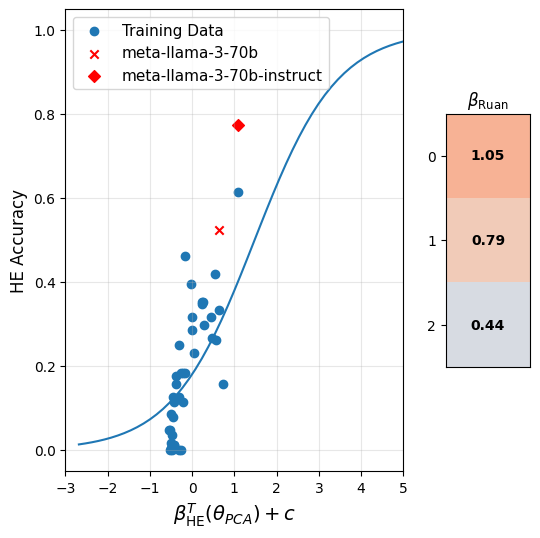

In [9]:
x, y = np.concatenate((X_ruan, Inter_train), axis = 1) @ B_ood_ruan, Y_tr
x_test, y_test = np.concatenate((Z_hold_ruan, np.ones(2)[np.newaxis, :].T), axis = 1) @ B_ood_ruan, Y_hold
a, b, c, e = np.linspace(-2, 10, 100), np.linspace(-2, 10, 100), np.linspace(-2, 10, 100), np.linspace(-2, 10, 100)
Grid = np.vstack((a.flatten(), b.flatten(), c.flatten())).T
y_curve = model_ood.predict(Grid, np.array([[1]]))
x_grid = np.concatenate((Grid, np.ones(100)[np.newaxis, :].T), axis = 1) @ B_ood
colormap = "coolwarm"
vmin=-1
vmax=2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,6), width_ratios=[4, 1])
 # Set the figure size (width, height) in inches
#ax1.set_figwidth(6)
#ax1.set_figheight(3)
Bperm = B_ood_ruan.copy()
#Bperm[[0,1,2]] = Bperm[[0, 2,1]]
ax2.imshow(Bperm[0:3], cmap=colormap, vmin=vmin, vmax=vmax)
inter = [-.3,1.6]
for i in range(len(B_ood_ruan[0:3])):
    for j in range(len(B_ood_ruan[0:3].T)):
        value = Bperm[0:3][i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = ax2.text(j, i, f'{value:.2f}', size=10, ha="center", va="center", color=color, weight='bold')#
ax2.set_xticks([], [])  # Set the x-tick labels
ax2.set_yticks(np.arange(d))  # Set the y-tick labels
ax2.set_title('$\\beta_{\\text{Ruan}}$', size = 12)
#ax2.tick_params(labelsize=11)
ax1.scatter(x,y, label = 'Training Data')
ax1.scatter(x_test[0],y_test[0], color = 'red', label = 'meta-llama-3-70b', marker = 'x')
ax1.scatter(x_test[1],y_test[1], color = 'red', label = 'meta-llama-3-70b-instruct', marker = 'D')
ax1.set_xlim(-3, 5)
#ax2.ylim(0,1)
ax1.set_xlabel('$\\beta_{\\text{HE}}^T(\\theta_{PCA}) +c$', size = 14)
ax1.grid(alpha = 0.3)
ax1.plot(x_grid, y_curve)
ax1.set_ylabel('HE Accuracy', size = 12)
#ax2.tick_params(labelsize=11)
ax1.legend(prop={'size':11}, loc = 'upper left')
plt.savefig('../plots/HE_Plot_ruan.pdf', bbox_inches='tight')
plt.show()

# EQ

In [10]:
#data = pd.read_csv('data/data_v2.csv')
#data['logS'] = np.log10(data['#Params (B)'])
#data['logT'] = np.log10(data['Pretraining Data Size (T)'])
#data['logSlogT'] = data['logS']*data['logT']
#data['logS2'] = data['logS']**2
#data['logT2'] = data['logT']**2
#data['GreatFamily'] = data['Family']
#data['Family'] = data['Family2']
#X_names = ['logS','logT','logSlogT'] 
Y_names = ['GSM8K',
           'MATH Lvl 5',
           'GPQA',
           'MMLU',
           'MMLU-PRO',
           'BBH',
           'MUSR',
           'TruthfulQA',
           'ARC',
           'HellaSwag',
           'Winogrande',
           'IFEval']
EQ_dat = {'meta-llama-3-70b-instruct': 82.13, 'yi-1.5-34b-chat': 72.93, 
          'qwen1.5-32b-chat': 75.59, 'meta-llama-3-8b-instruct': 68.88, 
          'yi-34b-chat': 71.62, 'yi-1.5-9b-chat':70.37, 
          'qwen1.5-14b-chat': 74.99, 'llama-2-70b-chat': 73.59, 
          'yi-1.5-6b-chat': 59.45,'qwen1.5-7b-chat': 54.41, 'gemma-7b-it': 61.72,
            'llama-2-13b-chat': 49.12, 'llama-2-7b-chat': 36.32, 'qwen1.5-4b-chat': 28.75, 'qwen1.5-1.8b-chat': 24.12  }
holdout_names = ['meta-llama-3-70b-instruct']
data_EQ = data.loc[:,['Model','Family','GreatFamily','Instruct']+X_names+Y_names].dropna()
data_hold = data_EQ.loc[data['Model'].isin(holdout_names)]
Models_dict = {k: v for v, k in enumerate(list(data_EQ['Model']))}
to_drop = []
for model in holdout_names:
    to_drop.append(Models_dict[model])
to_drop.sort()
for name in holdout_names:
    data_EQ = data_EQ[data.Model != name]
Skills_dict = {k: v for v, k in enumerate(list(data_EQ['Model']))}
to_keep = []
Y_tr = []
for model in list(EQ_dat.keys()):
    if model != holdout_names[0]:
        try:
            to_keep.append(Skills_dict[model])
            Y_tr.append(EQ_dat[model])
        except:
            print(model)
X_tr = Z[to_keep]
Inter_train  = np.ones(X_tr.shape[0])[np.newaxis, :].T
Y_tr = np.array(Y_tr).astype(float)
Y_tr = Y_tr[np.newaxis, :].T/100
Y_tr.shape
D_hold = D_whole[to_drop[0]]
#D_hold = D[to_drop]
X_hold = X_whole[to_drop[0]]
Y_hold = np.array([EQ_dat[holdout_names[0]]]).astype(float)
Y_hold = Y_hold[np.newaxis, :].T/100
Y_hold.shape

yi-34b-chat


/tmp/ipykernel_9218/1002484668.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_EQ = data_EQ[data.Model != name]


(1, 1)

In [11]:
model_ood = Sloth(d=1) 
model_ood.fit(X_tr, Inter_train, Y_tr,
                                      C0=np.array([[0]]),
                                      train_link=False, fit_C=False, positive_w=False, verbose=False)
Z_hold = np.hstack((X_hold,D_hold))@B_rot-Delta
B_ood=np.vstack((model_ood.W1_X.detach().numpy(), model_ood.W1_D.detach().numpy()))
B_ood

array([[-0.08077267],
       [ 0.6242662 ],
       [ 1.3405155 ],
       [ 0.27690354]], dtype=float32)

In [12]:
## Ruan et als method
import numpy as np
from sklearn.decomposition import PCA
#d=1
pca = PCA(n_components=3)
pca.fit(Y_whole)
X_ruan=pca.transform(Y_whole)[to_keep]
model_ood_ruan = Sloth(d=1) 
model_ood_ruan.fit(X_ruan, Inter_train, Y_tr,
                                      C0=np.array([[0]]),
                                      train_link=False, fit_C=False, positive_w=False, verbose=False)
Z_hold_ruan = pca.transform(Y_whole)[to_drop]
B_ood_ruan = np.vstack((model_ood_ruan.W1_X.detach().numpy(), model_ood_ruan.W1_D.detach().numpy()))

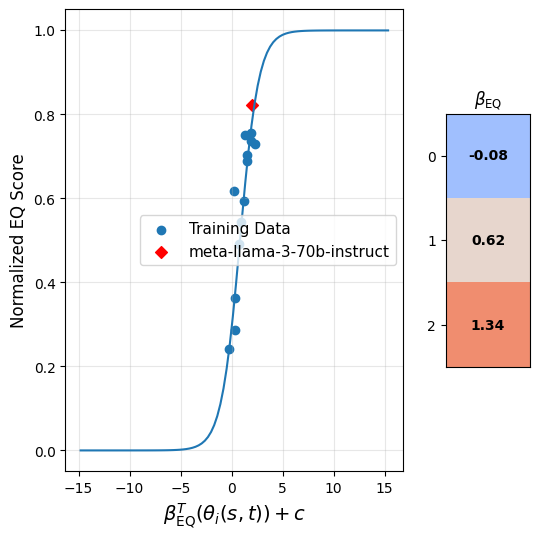

In [13]:
x, y = np.concatenate((X_tr, Inter_train), axis = 1) @ B_ood, Y_tr
x_test, y_test = np.concatenate((Z_hold, np.ones(1)[np.newaxis, :].T), axis = 1) @ B_ood, Y_hold
a, b, c, e = np.linspace(-8, 8, 100), np.linspace(-8, 8, 100), np.linspace(-8, 8, 100), np.linspace(-8, 2, 100)
Grid = np.vstack((a.flatten(), b.flatten(), c.flatten())).T
y_curve = model_ood.predict(Grid, np.array([[1]]))
x_grid = np.concatenate((Grid, np.ones(100)[np.newaxis, :].T), axis = 1) @ B_ood
colormap = "coolwarm"
vmin=-1
vmax=2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,6), width_ratios=[4, 1])
 # Set the figure size (width, height) in inches
#ax1.set_figwidth(6)
#ax1.set_figheight(3)
ax2.imshow(B_ood[0:3], cmap=colormap, vmin=vmin, vmax=vmax)
inter = [-.3,1.6]
for i in range(len(B_ood[0:3])):
    for j in range(len(B_ood[0:3].T)):
        value = B_ood[0:3][i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = ax2.text(j, i, f'{value:.2f}', size=10, ha="center", va="center", color=color, weight='bold')#
ax2.set_xticks([], [])  # Set the x-tick labels
ax2.set_yticks(np.arange(d))  # Set the y-tick labels
ax2.set_title('$\\beta_{\\text{EQ}}$', size = 12)
#ax2.tick_params(labelsize=11)
ax1.scatter(x,y, label = 'Training Data')
ax1.scatter(x_test,y_test, color = 'red', label = 'meta-llama-3-70b-instruct', marker = 'D')
#ax1.set_xlim(-4, 4)
#ax2.ylim(0,1)
ax1.set_xlabel('$\\beta_{\\text{EQ}}^T(\\theta_{i}(s,t)) +c$', size = 14)
ax1.grid(alpha = 0.3)
ax1.plot(x_grid, y_curve)
ax1.set_ylabel('Normalized EQ Score', size = 12)
#ax2.tick_params(labelsize=11)
ax1.legend(prop={'size':11})
plt.savefig('../plots/EQ_Plot_rebuttal.pdf', bbox_inches='tight')
plt.show()

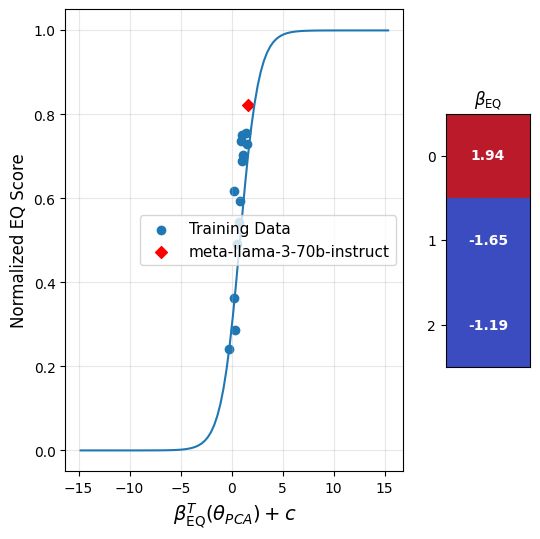

In [14]:
x, y = np.concatenate((X_ruan, Inter_train), axis = 1) @ B_ood_ruan, Y_tr
x_test, y_test = np.concatenate((Z_hold_ruan, np.ones(1)[np.newaxis, :].T), axis = 1) @ B_ood_ruan, Y_hold
a, b, c, e = np.linspace(-8, 8, 100), np.linspace(-8, 8, 100), np.linspace(-8, 8, 100), np.linspace(-8, 2, 100)
Grid = np.vstack((a.flatten(), b.flatten(), c.flatten())).T
y_curve = model_ood.predict(Grid, np.array([[1]]))
x_grid = np.concatenate((Grid, np.ones(100)[np.newaxis, :].T), axis = 1) @ B_ood
colormap = "coolwarm"
vmin=-1
vmax=2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,6), width_ratios=[4, 1])
 # Set the figure size (width, height) in inches
#ax1.set_figwidth(6)
#ax1.set_figheight(3)
ax2.imshow(B_ood_ruan[0:3], cmap=colormap, vmin=vmin, vmax=vmax)
inter = [-.3,1.6]
for i in range(len(B_ood_ruan[0:3])):
    for j in range(len(B_ood_ruan[0:3].T)):
        value = B_ood_ruan[0:3][i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = ax2.text(j, i, f'{value:.2f}', size=10, ha="center", va="center", color=color, weight='bold')#
ax2.set_xticks([], [])  # Set the x-tick labels
ax2.set_yticks(np.arange(d))  # Set the y-tick labels
ax2.set_title('$\\beta_{\\text{EQ}}$', size = 12)
#ax2.tick_params(labelsize=11)
ax1.scatter(x,y, label = 'Training Data')
ax1.scatter(x_test,y_test, color = 'red', label = 'meta-llama-3-70b-instruct', marker = 'D')
#ax1.set_xlim(-4, 4)
#ax2.ylim(0,1)
ax1.set_xlabel('$\\beta_{\\text{EQ}}^T(\\theta_{PCA}) +c$', size = 14)
ax1.grid(alpha = 0.3)
ax1.plot(x_grid, y_curve)
ax1.set_ylabel('Normalized EQ Score', size = 12)
#ax2.tick_params(labelsize=11)
ax1.legend(prop={'size':11})
plt.savefig('../plots/EQ_Plot_ruan.pdf', bbox_inches='tight')
plt.show()